In [ ]:
!pip install permetrics

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from google.colab import files
from permetrics.regression import RegressionMetric
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, recall_score
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Ciencia de Datos/Diplomado Data Science/modulo 5/clase 3/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Type tipo de maquina (categorica, low, medium or hight performance)

Air temperature temperatura (numerica)

Process temperature temperatura interna (numerica)

Rotational speed velocidad de rotacion (rpm)

Torque medida de fuerza (numerica)

Tool wear desgaste (medido en tiempo)

Machine failure falla general, variable objetivo

TWF fallo por desgaste (binaria)

HDF fallo por problema de disipacion termica (binaria)

PWF fallo por energia (binaria)

OSF fallo por sobrecarga mecanica (binaria)

RNF fallo aleatorio (binaria)

Eliminamos: TWF, HDF, PWF, OSF y RNF porque ellas estan enmarcadas en el target: Machine failure

Comenzamos con el pre-procesamiento de los datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [ ]:
df_1 = df[df['Machine failure'] == 1]
df_0 = df[df['Machine failure'] == 0]
print(f'Porcentaje de maquinas que fallan {df_1.shape[0]/100}%')
print(f'Porcentaje de maquinas que no falla {df_0.shape[0]/100}%')


Porcentaje de maquinas que fallan 3.39%
Porcentaje de maquinas que no falla 96.61%


In [ ]:
df = df.drop(columns=["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


Variables controlables: Process temperature, Rotational speed, torque, tool wear
Variables incontrolables: Type, air temperature

In [ ]:
df2 = df.select_dtypes(exclude=['object'])
df2=df2.drop(columns=["Machine failure"])

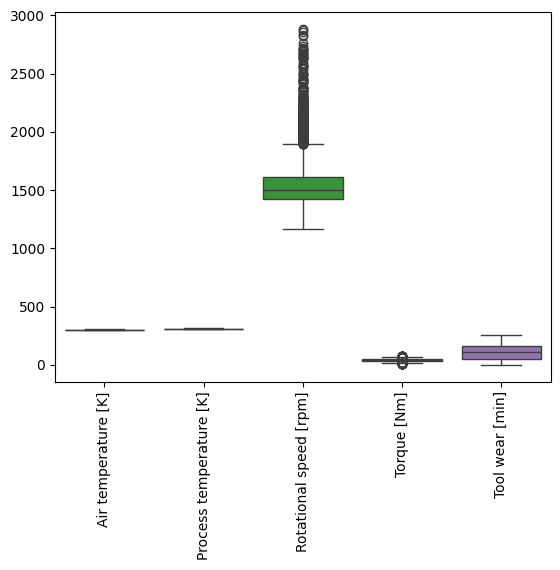

In [ ]:
sns.boxplot(df2)
plt.xticks(rotation=90)
plt.show()

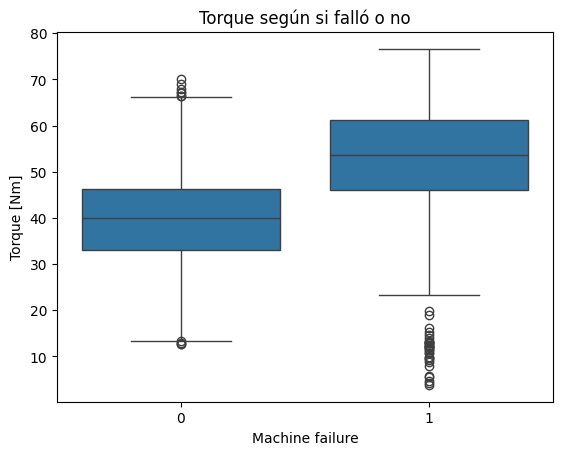

In [ ]:
sns.boxplot(x='Machine failure', y='Torque [Nm]', data=df)
plt.title("Torque según si falló o no")
plt.show()

Por medio de los boxplots separados para "falla" y "no falla" podemos ver que en pricipio la maquina falla para valores de toruqe mayores

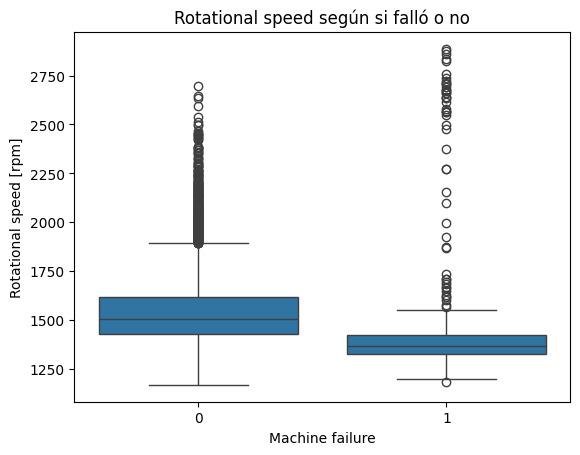

In [ ]:
sns.boxplot(x='Machine failure', y='Rotational speed [rpm]', data=df)
plt.title("Rotational speed según si falló o no")
plt.show()

De estos boxplots podemos intuir que la maquina falla cuando disminuye la velocidad rotacional y esto es coherente con los boxplots de torque

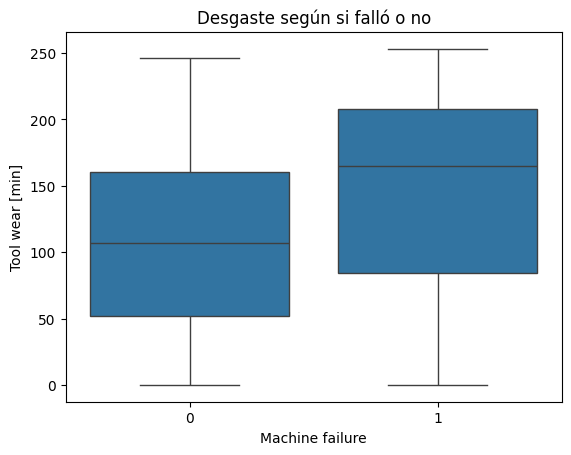

In [ ]:
sns.boxplot(x='Machine failure', y='Tool wear [min]', data=df)
plt.title("Desgaste según si falló o no")
plt.show()

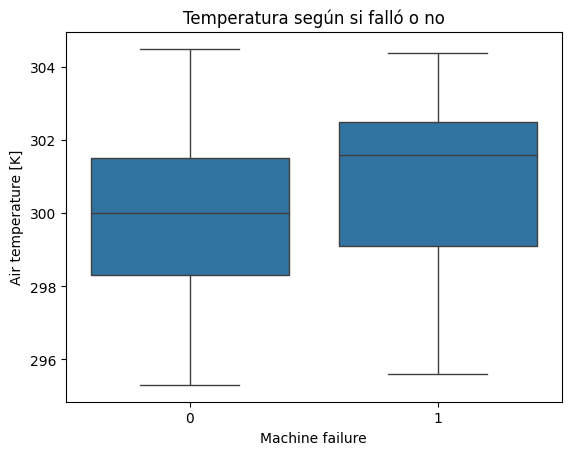

In [ ]:
sns.boxplot(x='Machine failure', y='Air temperature [K]', data=df)
plt.title("Temperatura según si falló o no")
plt.show()

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  int64  
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 390.8 KB


In [ ]:
scaler = StandardScaler()
Datos2_scaled = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

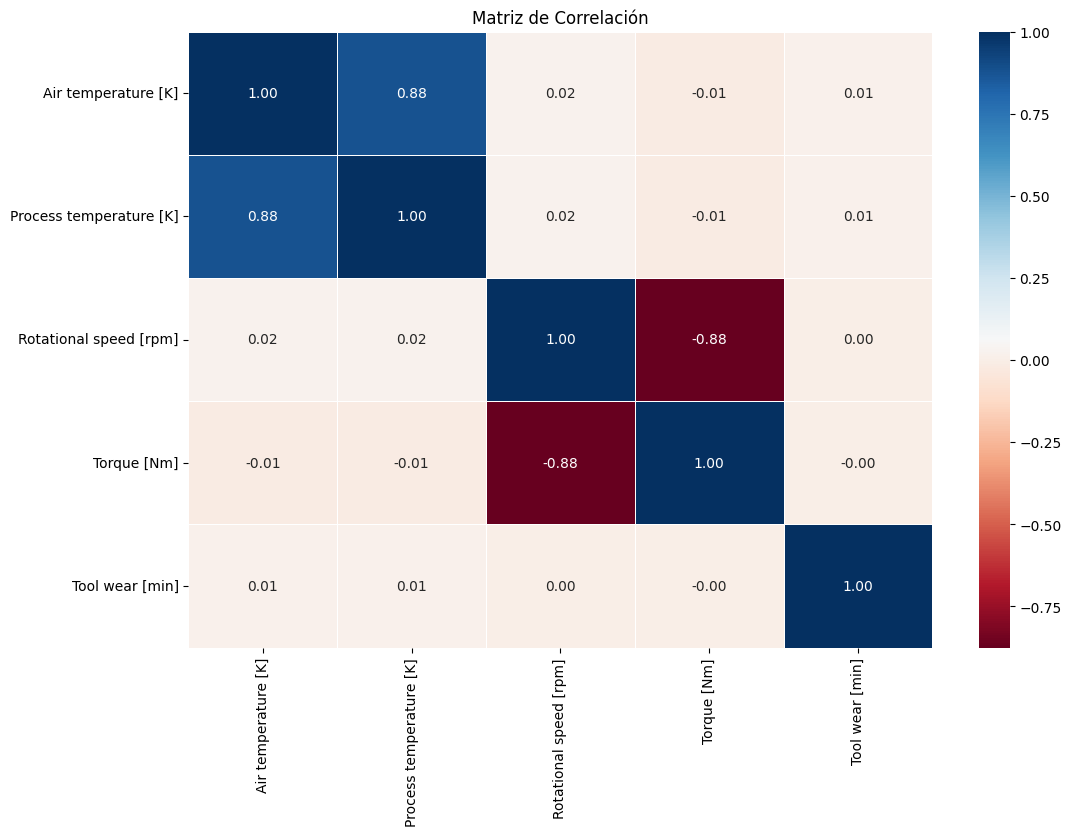

In [ ]:
corr_matrix = Datos2_scaled.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

Modelo explicativo

In [ ]:
X = df.drop(['Machine failure'], axis=1)
Y = df['Machine failure']
X.info()
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 468.9+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: Machine failure
Non-Null Count  Dtype
--------------  -----
10000 non-null  int64
dtypes: int64(1)
memory usage: 78.3 KB


In [ ]:
variables_numericas = X.select_dtypes(exclude='object').columns.tolist()
variables_categoricas = X.select_dtypes(include='object').columns.tolist()
scaler = StandardScaler()
scaler.fit(X[variables_numericas])

X_num_scaled = pd.DataFrame(scaler.transform(X[variables_numericas]), columns=X[variables_numericas].columns.tolist())
X_num_scaled

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588
...,...,...,...,...,...
9995,-0.602417,-1.082162,0.363820,-1.052012,-1.476034
9996,-0.552421,-1.082162,0.520005,-0.821283,-1.428902
9997,-0.502425,-0.947360,0.592519,-0.660777,-1.350349
9998,-0.502425,-0.879959,-0.729472,0.854005,-1.303217


In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[variables_categoricas])

X_cat_ohe = pd.DataFrame(ohe.transform(X[variables_categoricas]).toarray(), columns=ohe.get_feature_names_out(X[variables_categoricas].columns.tolist()))
X_cat_ohe

,Type_H,Type_L,Type_M
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
9995,0.0,0.0,1.0
9996,1.0,0.0,0.0
9997,0.0,0.0,1.0
9998,1.0,0.0,0.0


In [ ]:
X_preprocesada = pd.concat([X_num_scaled, X_cat_ohe], axis=1)
X_preprocesada

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0.0,1.0,0.0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
9995,-0.602417,-1.082162,0.363820,-1.052012,-1.476034,0.0,0.0,1.0
9996,-0.552421,-1.082162,0.520005,-0.821283,-1.428902,1.0,0.0,0.0
9997,-0.502425,-0.947360,0.592519,-0.660777,-1.350349,0.0,0.0,1.0
9998,-0.502425,-0.879959,-0.729472,0.854005,-1.303217,1.0,0.0,0.0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_preprocesada, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
accuracy = model.score(X_test, Y_test)
print("Accuracy en test:", accuracy)

Accuracy en test: 0.8245


In [ ]:
importancia = pd.Series(model.coef_[0], index=X_train.columns).sort_values(key=abs, ascending=False)

print(importancia)

Torque [Nm]                2.393817
Air temperature [K]        1.785116
Rotational speed [rpm]     1.715066
Process temperature [K]   -1.235481
Tool wear [min]            0.861840
Type_H                    -0.551209
Type_M                    -0.547057
Type_L                    -0.085294
dtype: float64


A mayor torque mayor probabilidad de falla (importancia 1)

A mayor Air temperature mayor probabilidad de falla (importancia 2)

A mayor Rotational speed mayor probabilidad de falla (importancia 3)

A mayor Process temperature menor probabilidad de falla (importancia 4)

A mayor tool wear mayor probabilidad de falla

A mayor performance menor probabilidad de falla de la maquina


Modelo predictivo

In [ ]:
def preparar_dataset(df, target_col, test_size=0.2, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y if y.nunique() <= 10 else None)

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    smote = SMOTE(random_state=random_state)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test, preprocessor

X_train, X_test, y_train, y_test, preprocessor = preparar_dataset(df, target_col='Machine failure')


Se utilizo smote sobre los datos de entrenamiento solamente, para balancear las clases

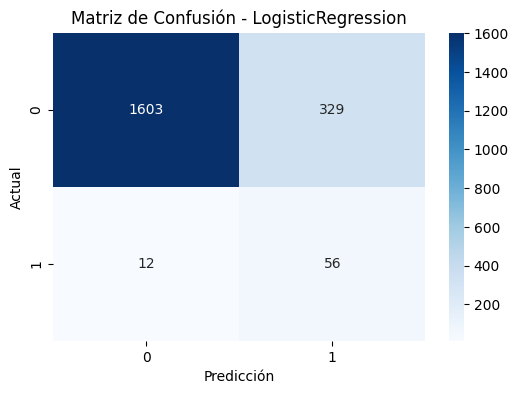

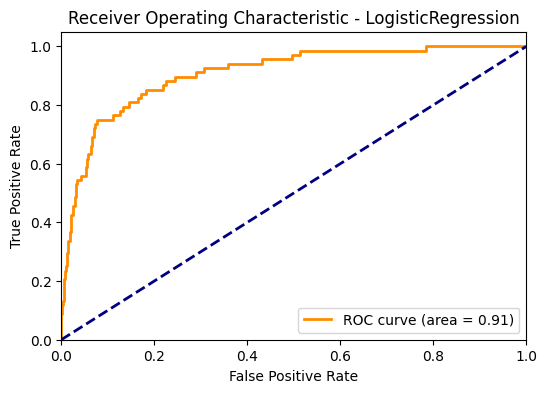

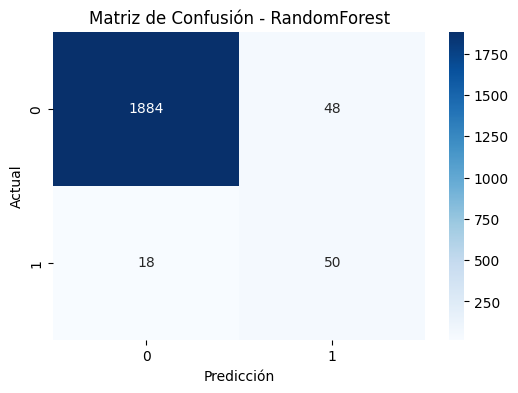

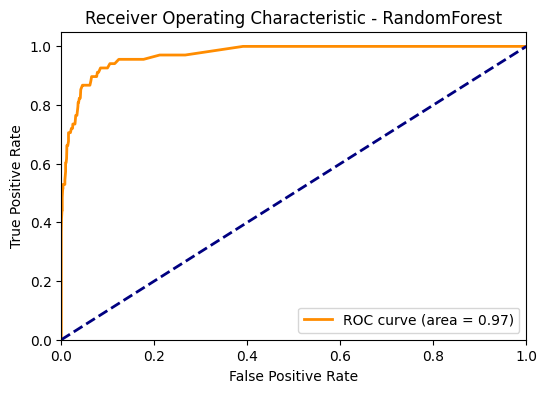

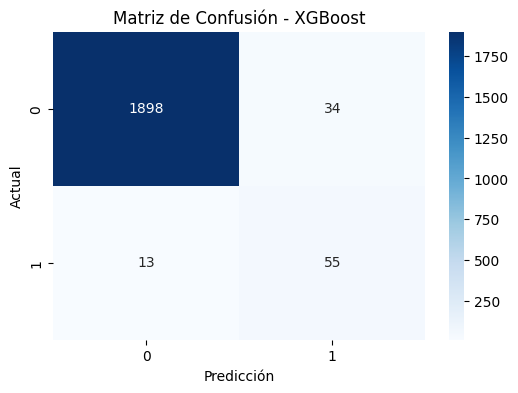

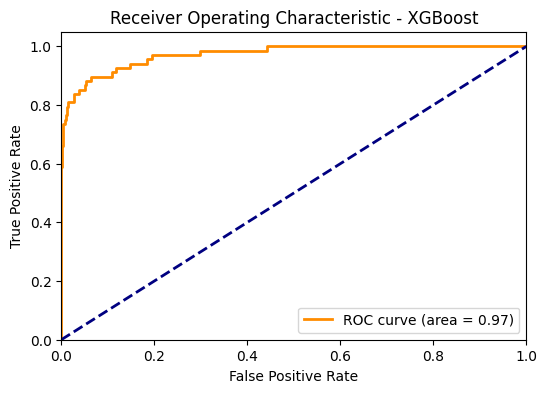

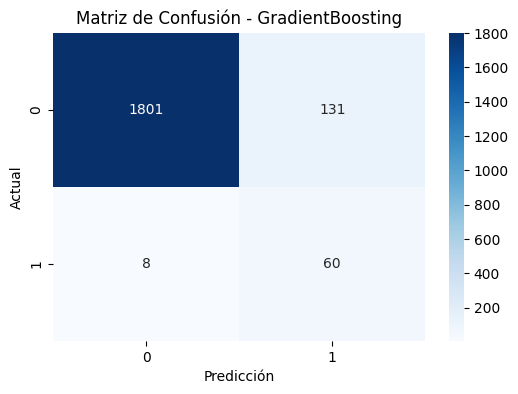

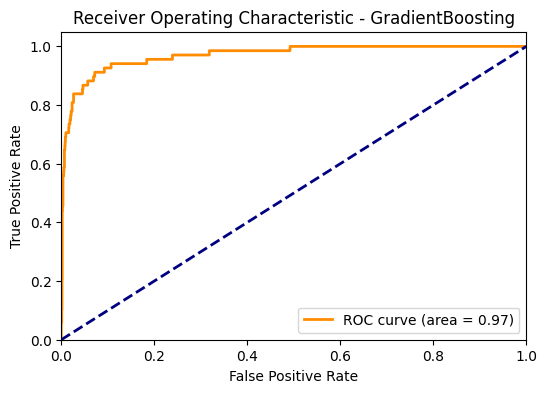

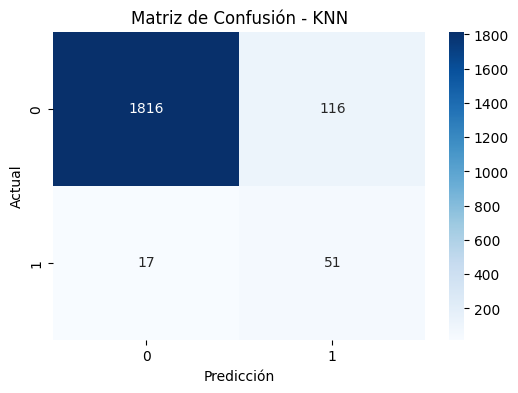

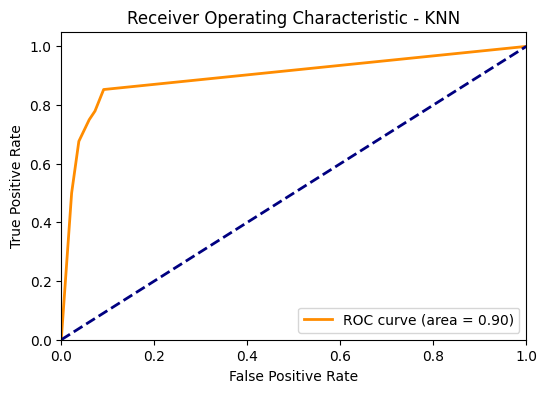

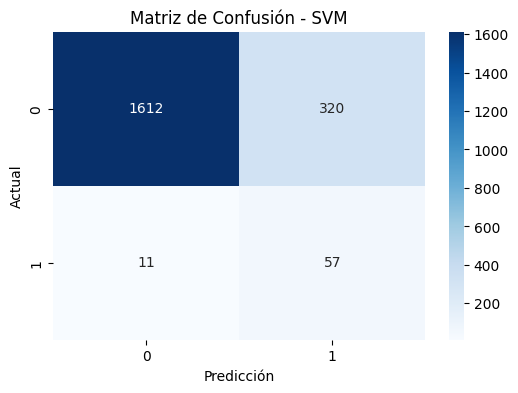

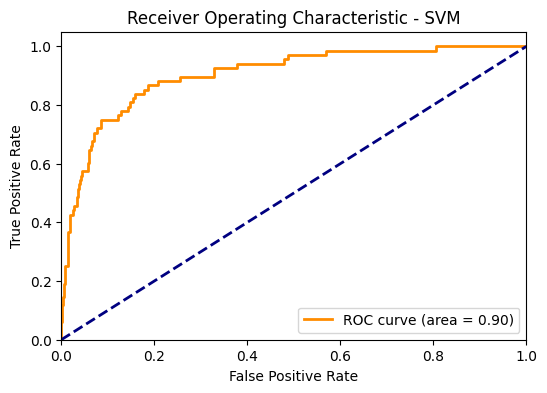

               Modelo  Accuracy  F1-score  Recall  ROC-AUC  \
0  LogisticRegression     0.830     0.882   0.830    0.908   
1        RandomForest     0.967     0.970   0.967    0.972   
2             XGBoost     0.977     0.978   0.977    0.973   
3    GradientBoosting     0.930     0.946   0.930    0.970   
4                 KNN     0.933     0.947   0.933    0.897   
5                 SVM     0.835     0.885   0.835    0.905   

          Confusion Matrix  
0  [[1603, 329], [12, 56]]  
1   [[1884, 48], [18, 50]]  
2   [[1898, 34], [13, 55]]  
3   [[1801, 131], [8, 60]]  
4  [[1816, 116], [17, 51]]  
5  [[1612, 320], [11, 57]]  


In [ ]:
def es_problema_clasificacion(y):
    return y.nunique() <= 10 and y.dtype in ['int64', 'int32']

def entrenar_modelos(X_train, X_test, y_train, y_test):
    resultados = []
    es_clasificacion = es_problema_clasificacion(y_train)

    if es_clasificacion:
        modelos = {
            'LogisticRegression': LogisticRegression(max_iter=500),
            'RandomForest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(eval_metric='mlogloss'),
            'GradientBoosting': GradientBoostingClassifier(),
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'SVM': SVC(kernel='linear', probability=True)
        }
    else:
        modelos = {
            'LinearRegression': LinearRegression(),
            'RandomForest': RandomForestRegressor(),
            'XGBoost': XGBRegressor(),
            'GradientBoosting': GradientBoostingRegressor(),
            'SVR': SVR(kernel='linear'),
            'KNN': KNeighborsRegressor(n_neighbors=5)
        }

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        if es_clasificacion:
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred)
            cr = classification_report(y_test, y_pred)
            fpr, tpr, thresholds = roc_curve(y_test, modelo.predict_proba(X_test)[:, 1], pos_label=1)
            roc_auc = auc(fpr, tpr)
            resultados.append({
                'Modelo': nombre,
                'Accuracy': round(acc, 3),
                'F1-score': round(f1, 3),
                'Recall': round(recall, 3),
                'ROC-AUC': round(roc_auc, 3),
                'Confusion Matrix': cm
            })

            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modelo.classes_, yticklabels=modelo.classes_)
            plt.title(f'Matriz de Confusión - {nombre}')
            plt.ylabel('Actual')
            plt.xlabel('Predicción')
            plt.show()

            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic - {nombre}')
            plt.legend(loc='lower right')
            plt.show()
        else:
            mse = mean_squared_error(y_test, y_pred)
            rmse = mse**0.5
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)

            resultados.append({
                'Modelo': nombre,
                'MSE': round(mse, 3),
                'RMSE': round(rmse, 3),
                'R2': round(r2, 3),
                'MAE': round(mae, 3)
            })

    return pd.DataFrame(resultados)

resultados_modelos = entrenar_modelos(X_train, X_test, y_train, y_test)
print(resultados_modelos)


Modelo Predictivo (Random Forest)


In [ ]:
param_grid = ParameterGrid(
                {'n_estimators': [100, 150, 200],
                 'max_features': [5, 6, 7, 8, 9],
                 'max_depth'   : [None, 3, 5, 8, 10, 13, 15, 18, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )


resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:

    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42,
                ** params
             )

    modelo.fit(X_train, y_train)

    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")


resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns='params')
resultados.head(4)


Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'n_estimators': 150} ✓

,oob_accuracy,criterion,max_depth,max_features,n_estimators
257,0.987450,entropy,20.0,5,200
137,0.987126,entropy,NaN,5,200
260,0.986997,entropy,20.0,6,200
135,0.986997,entropy,NaN,5,100


In [ ]:
modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42,
                n_estimators = 200,
                max_features = 5,
                max_depth    = 20,
                criterion    = 'entropy',
                class_weight = 'balanced'
                )

In [ ]:
modelo.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=5, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
oob_accuracy = modelo.oob_score_

In [ ]:
predicciones = modelo.predict(X=X_test)
predicciones[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Matriz de confusión
-------------------
[[1892   40]
 [  13   55]]

El accuracy de test es: 97.35000000000001 % 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.58      0.81      0.67        68

    accuracy                           0.97      2000
   macro avg       0.79      0.89      0.83      2000
weighted avg       0.98      0.97      0.98      2000



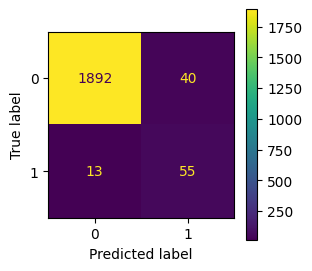

In [ ]:
mat_confusion = confusion_matrix(y_true=y_test, y_pred=predicciones)
accuracy = accuracy_score(y_true=y_test, y_pred=predicciones, normalize=True)
print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} % \n")
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay(mat_confusion).plot(ax=ax)

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)